In [551]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.ndimage.morphology as m
import mahotas as mh
from skimage import measure
from skimage.measure import approximate_polygon

In [552]:
SRC_FINGER_IMG = '/volumes/Second/documents/sources/DDNA/DB1_B/101_1.bmp'

In [553]:
def build_filters():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters
 
def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum

In [554]:
def endPoints(skel):
    endpoint1=np.array([[0, 0, 0],
                        [0, 1, 0],
                        [2, 1, 2]])
    
    endpoint2=np.array([[0, 0, 0],
                        [0, 1, 2],
                        [0, 2, 1]])
    
    endpoint3=np.array([[0, 0, 2],
                        [0, 1, 1],
                        [0, 0, 2]])
    
    endpoint4=np.array([[0, 2, 1],
                        [0, 1, 2],
                        [0, 0, 0]])
    
    endpoint5=np.array([[2, 1, 2],
                        [0, 1, 0],
                        [0, 0, 0]])
    
    endpoint6=np.array([[1, 2, 0],
                        [2, 1, 0],
                        [0, 0, 0]])
    
    endpoint7=np.array([[2, 0, 0],
                        [1, 1, 0],
                        [2, 0, 0]])
    
    endpoint8=np.array([[0, 0, 0],
                        [2, 1, 0],
                        [1, 2, 0]])
    
    ep1=mh.morph.hitmiss(skel,endpoint1)
    ep2=mh.morph.hitmiss(skel,endpoint2)
    ep3=mh.morph.hitmiss(skel,endpoint3)
    ep4=mh.morph.hitmiss(skel,endpoint4)
    ep5=mh.morph.hitmiss(skel,endpoint5)
    ep6=mh.morph.hitmiss(skel,endpoint6)
    ep7=mh.morph.hitmiss(skel,endpoint7)
    ep8=mh.morph.hitmiss(skel,endpoint8)
    ep = ep1+ep2+ep3+ep4+ep5+ep6+ep7+ep8
    return ep

def pruning(skeleton, size):
    '''remove iteratively end points "size" 
       times from the skeleton
    '''
    for i in range(0, size):
        endpoints = endPoints(skeleton)
        endpoints = np.logical_not(endpoints)
        skeleton = np.logical_and(skeleton,endpoints)
    return skeleton

def rotate(image, angle, center=None, scale=1.0):
    # grab the dimensions of the image
    (h, w) = image.shape[:2]

    # if the center is None, initialize it as the center of
    # the image
    if center is None:
        center = (w / 2, h / 2)

    # perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))

    # return the rotated image
    return rotated


In [555]:
img_src = cv2.imread(SRC_FINGER_IMG, 0)

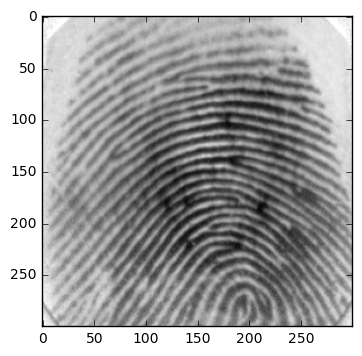

In [556]:
%matplotlib inline
imshow(img_src, 'gray')

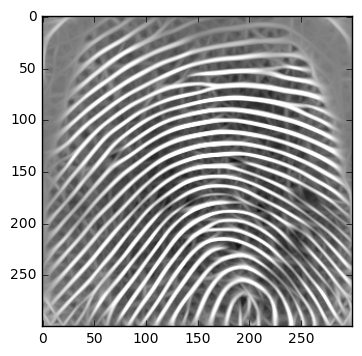

In [557]:
filters = build_filters()
img_gabor = process(img_src, filters)


%matplotlib inline
imshow(img_gabor, cmap="gray")

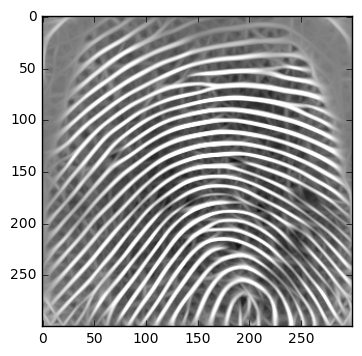

In [558]:
img_gaus = cv2.GaussianBlur(img_gabor,(1,1),0)
imshow(img_gaus, cmap="gray")

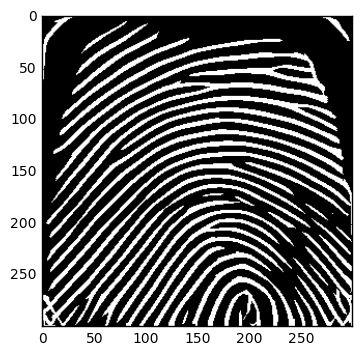

In [559]:
(thresh, img_otsu) = cv2.threshold(img_gaus, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
imshow(img_otsu, cmap="gray")

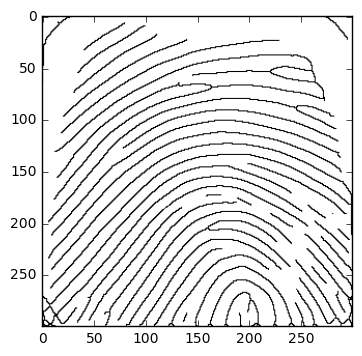

In [560]:
img_skel = np.invert(pruning(mh.thin(img_otsu),3))
imshow(img_skel, cmap="gray")

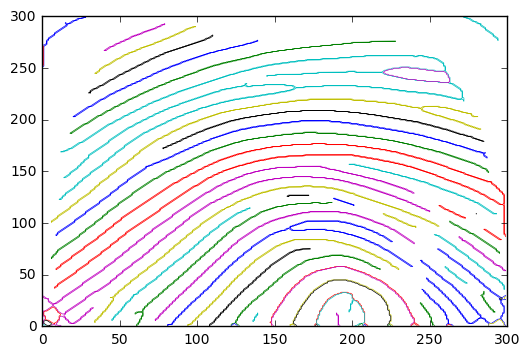

In [561]:
contours = measure.find_contours(img_skel, 0.1)
for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], 300 - contour[:, 0], linewidth=0.5)